# Cross-validating interpolation kernels

In order to check if the Lanczos interpolation kernels in GalSim and in the LSST stack are identical, and if not, to understand the differences, we perform a simple check here.

In [2]:
## Do the imports and call the butler

from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.meas.algorithms as measAlg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import galsim

In [56]:
normalisation_ratios = [] ## you'll understand its purpose later

Draw a Gaussian image and interpolate to half the pixel size. We first test our implemention, particularly involving flux normalization, pixel origin conventions etc. are consistent between GalSim and LSST stack

## Bilinear interpolation

In [129]:
gauss = galsim.Gaussian(sigma=0.7)#.shear(g1=0.3,g2=0.4)
#gauss = galsim.Convolve([galsim.Gaussian(sigma=1.2).shear(g1=0.03,g2=0.04), galsim.Exponential(half_light_radius=1.7).shear(g1=-0.1,g2=0.08)])
gauss_img = galsim.Image(ncol=41,nrow=41,init_value=4.)
gauss_img = gauss.drawImage(image=gauss_img, method='no_pixel',scale=0.5)
gauss_img.scale = 0.5
afwExp_array = np.array(gauss_img.array, dtype=np.float64)
afwExp = afwImage.ImageD(array=afwExp_array, deep=False, xy0=geom.Point2I(0,0))

#### LSST stack implemention

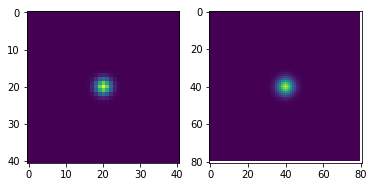

In [130]:
lT = geom.AffineTransform(linear=2.*np.eye(2))
wc = afwMath.WarpingControl(warpingKernelName='bilinear')
destImage = afwImage.ImageD(array=np.zeros((81,81)),deep=False,xy0=geom.Point2I(0,0))
_warp = afwMath.warpImage(destImage=destImage, srcImage=afwExp, srcToDest=afwGeom.makeTransform(lT), control=wc)
fig, ax = plt.subplots(1,2)
ax[0].imshow(afwExp_array)
ax[1].imshow(destImage.array)

#### GalSim implementation

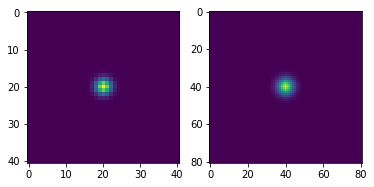

In [131]:
gauss_ii = galsim.InterpolatedImage(gauss_img, x_interpolant='linear')
gauss_hires = galsim.Image(np.zeros_like(destImage.array))
gauss_hires = gauss_ii.drawImage(image=gauss_hires, method='no_pixel',scale=0.25)
fig, ax = plt.subplots(1,2)
ax[0].imshow(gauss_img.array)
ax[1].imshow(gauss_hires.array)

In [132]:
np.testing.assert_array_equal(destImage.array[0:79:2,0:79:2], 0.25*afwExp_array[:-1,:-1])
np.testing.assert_array_equal(destImage.array[1:79:2,1:79:2], 0.25*(destImage.array[2:80:2,0:78:2] + destImage.array[2:80:2,2:80:2] + destImage.array[0:78:2,2:80:2] + destImage.array[0:78:2,0:78:2]))

np.testing.assert_array_equal(gauss_hires.array[:80,:80], destImage.array[:80,:80])

If the above assertions are true, then it indicates that GalSim and LSST stack behaviours are identical, and they also do what we expect them to do. Time to move on to Lanczos kernels

## Lanczos interpolation

In [133]:
lanczos_order = 3
kernel_name = 'lanczos{0}'.format(lanczos_order)
x_interpolant = galsim.Lanczos(n=lanczos_order, conserve_dc=True)
lT = geom.AffineTransform(linear=2.*np.eye(2))
wc = afwMath.WarpingControl(warpingKernelName=kernel_name)
destImage = afwImage.ImageD(array=np.zeros((81,81)),deep=False,xy0=geom.Point2I(0,0))
_warp = afwMath.warpImage(destImage=destImage, srcImage=afwExp, srcToDest=afwGeom.makeTransform(lT), control=wc)

In [134]:
gauss_ii = galsim.InterpolatedImage(gauss_img, x_interpolant=x_interpolant)
gauss_hires = galsim.Image(np.zeros_like(destImage.array))
gauss_hires = gauss_ii.drawImage(image=gauss_hires, method='no_pixel',scale=0.25)

In [135]:
arr1 = gauss_hires.array[5:-5,5:-5]
arr2 = destImage.array[5:-5,5:-5]
print("arr1 = ", arr1)
print("arr2 = ", arr2)
print("orig = ", 0.25*gauss_img.array[2:5,2:5])
print("Max values = ", arr1.max(), np.nanmax(arr2), 0.25*gauss_img.array.max())

arr1 =  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.19071912e-49 ... 4.19071912e-49
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 4.19071912e-49 ... 4.19071912e-49
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
arr2 =  [[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.61787352e-111 2.60385802e-080 ... 2.60385802e-080
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.60385802e-080 4.19073339e-049 ... 4.19073339e-049
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 2.60385802e-080 4.19073339e-049 ... 4.19073339

First, make sure that original pixel values are present in the interpolated images

In [136]:
assert arr1.max()==arr2.max()
assert arr1.max()==0.25*(gauss_img.array.max())
np.testing.assert_array_equal(arr1[15:55:2,15:55:2], 0.25*gauss_img.array[10:30,10:30])
np.testing.assert_array_equal(arr2[15:55:2,15:55:2], 0.25*gauss_img.array[10:30,10:30])

AssertionError: 
Arrays are not equal

Mismatched elements: 353 / 400 (88.2%)
Max absolute difference: 8.67361738e-19
Max relative difference: 3.05573951e-13
 x: array([[1.411310e-24, 1.797302e-22, 1.374172e-20, 6.307862e-19,
        1.738379e-17, 2.876259e-16, 2.857148e-15, 1.703957e-14,
        6.101064e-14, 1.311517e-13, 1.692635e-13, 1.311517e-13,...
 y: array([[1.411310e-24, 1.797302e-22, 1.374172e-20, 6.307862e-19,
        1.738379e-17, 2.876259e-16, 2.857148e-15, 1.703957e-14,
        6.101064e-14, 1.311517e-13, 1.692635e-13, 1.311517e-13,...

Let us look at the difference images, only at the interpolated points

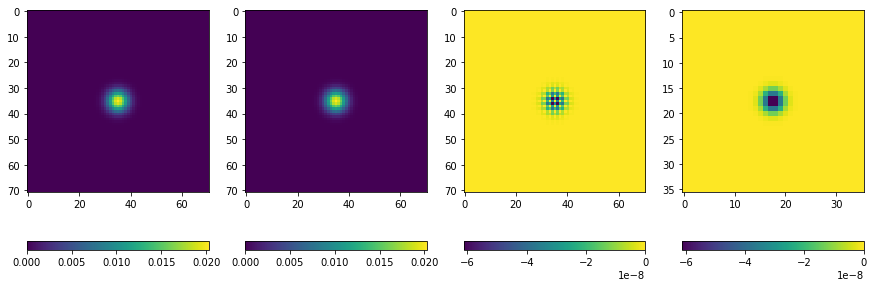

In [137]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(15,6)
_im = [None]*len(ax)
_im[0] = ax[0].imshow(arr1)
_im[1] = ax[1].imshow(arr2)
diff_im = arr1 - arr2
_im[2] = ax[2].imshow(diff_im)
_im[3] = ax[3].imshow(diff_im[::2,::2])
for ii in range(len(ax)):
    fig.colorbar(_im[ii],ax=ax[ii],orientation='horizontal')

If the difference image traced the profile, there is likely a normalization factor difference. Let's calculate the ratio of the pixel values

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Min =  nan ; Max =  nan : Std. Dev =  nan


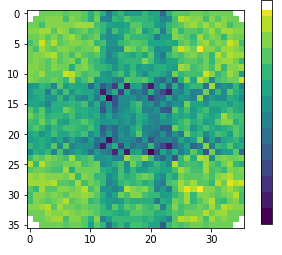

In [139]:
ratio_im = arr1[::2,::2]/arr2[::2,::2]
fig, ax = plt.subplots()
_im = ax.imshow(ratio_im)
_cbar = fig.colorbar(_im,ax=ax)
normalisation_ratios.append( (ratio_im.mean(), ratio_im.std(), ratio_im.min(), ratio_im.max()) )
print("Min = ", ratio_im.min(), "; Max = ", ratio_im.max(), ": Std. Dev = ", ratio_im.std())
norm_ratio = (arr1[::2,::2]/arr2[::2,::2]).mean()

The ratio is almost constant, and is close to unity. The fluctuations are likely due to numerical artifacts. We adopt the mean of the ratio as the fudge factor.

Is the value of the fudge factor independent of the profile drawn?

In [128]:
print("Mean, SD, Min, Max")
for nr in normalisation_ratios:
    print(nr)

Mean, SD, Min, Max
(0.9999965966876825, 2.054014465346515e-16, 0.9999965966876818, 0.9999965966876831)
(0.9999965966876825, 2.6367345960693474e-16, 0.9999965966876815, 0.9999965966876831)
(0.9999965966876825, 2.2101422996892028e-16, 0.9999965966876818, 0.9999965966876831)
(0.9999965966876825, 0.0, 0.9999965966876825, 0.9999965966876825)
(0.9999965966876825, 2.2101422996892028e-16, 0.9999965966876818, 0.9999965966876831)


The fudge factor is indeed independent of the profile drawn, indicating that this is a small difference in the kernel normalization

In [96]:
arr2.sum()/gauss_hires.array.sum(), arr2.sum()/gauss_img.array.sum()

(0.9983281771985437, 0.9982687877205186)

In [97]:
a = lanczos_order
L1 = lambda x: np.sin(x)*np.sin(x/a) if np.abs(x)<a else 0
L2 = lambda x: a*np.sin(np.pi*x)*np.sin(np.pi*x/a)/(np.pi*x)**2 if np.abs(x)<a else 0

L1(1)/L2(1)

8540482530161978.0

In [98]:
butler = Butler("/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_lanczos5/")

## Set some parameters
dataId = {'tract':9701, 'patch':'8,7', 'filter':'HSC-I'}
deepCoadd = butler.get("deepCoadd", dataId)

## Define the interpolation kernel
x_interpolant = "lanczos5"

coaddPsf = deepCoadd.getPsf()
coaddWcs = deepCoadd.getWcs()
bbox = deepCoadd.getBBox()

## Pick the midpoint of the coadd to compute the PSF there
point = geom.Point2D(0.5*(bbox.x.min+bbox.x.max), 0.5*(bbox.y.min+bbox.y.max))
print("Midpoint: ", point)
assert bbox.contains(geom.Point2I(point))

print("Bounding box of the coadd: ", bbox)
print("WCS of the coadd: ", coaddWcs)

## A set of convenience functions to convert an LSST WCS instance to an equivalent GalSim WCS instance
def convertWCS_radec(lsstWCS):
    ## A callable function using the LSST WCS that maps image coordinates to world/sky coordinates 
    def radecfunc(x,y):
        imgPoint = geom.Point2D(x,y)
        skyPoint = lsstWCS.pixelToSky(imgPoint)
        return skyPoint.getRa().asRadians(), skyPoint.getDec().asRadians()

    galsimWCS = galsim.RaDecFunction(ra_func=radecfunc)
    return galsimWCS

def convertWCS_pixelscale(lsstWCS):
    galsimWCS = galsim.PixelScale(lsstWCS.getPixelScale().asArcseconds())
    return galsimWCS

## Define an alias to whichever function you want to choose
convertWCS = convertWCS_pixelscale

# Generate the warpedPSF explicitly, and compare with that from the LSST stack

coaddWcs = deepCoadd.getWcs()
component_list = [ ]
xyTransform_list = [ ]
orig_psf_image_list = [ ]
orig_psf_image_copy_list = [ ]
galsim_warped_psf_image_list = [ ]
galsim_moments =  [ ]
moments = [ ]
psf_image_list = [ ]
psf_image_copy_list = [ ]
psf_weight_list = [ ]

wc = afwMath.WarpingControl(warpingKernelName='bilinear')

for i in range(coaddPsf.getComponentCount()):
    calexpPoint = deepCoadd.getPsf().getWcs(i).skyToPixel(coaddWcs.pixelToSky(geom.Point2D(point)))
    if deepCoadd.getPsf().getValidPolygon(i).contains(calexpPoint):
        component_list.append(i)
        #print(coaddPsf.computeBBox())
        xyTransform = afwGeom.makeWcsPairTransform(coaddPsf.getWcs(i), coaddWcs)
        xyTransform_list.append(xyTransform)
        orig_psf = coaddPsf.getPsf(i)
        orig_psf_image = orig_psf.computeKernelImage(xyTransform.applyInverse(point))
        orig_psf_image_copy = afwImage.ImageD(array=orig_psf_image.array, deep=True, xy0=geom.Point2I(0,0))
        print(type(orig_psf_image_copy))
        ## Modify the pixel values of orig_psf_image to see what the warping functions do
        if False:
            
            gaussian_image = galsim.Image(orig_psf_image.array)
            gaussian_image = galsim.Gaussian(sigma=3.2).drawImage(image=gaussian_image, scale=1.0)
            orig_psf_image.array = gaussian_image.array
            ## Uncomment the following lines to make the PSF image a point source
            #orig_psf_image.array *= 0.
            #orig_psf_image.array[20,20] = 1.
        
        warped_psf = measAlg.WarpedPsf(orig_psf, xyTransform, kernelName='bilinear')
        #print(coaddWcs, coaddPsf.getWcs(i))
        #print(orig_psf.computeBBox())
        print(warped_psf.getAveragePosition())
        print(xyTransform.applyForward(orig_psf.getAveragePosition()))
        psf_image = warped_psf.computeKernelImage(point)
        psf_image_list.append( psf_image )
 
        orig_psf_image_list.append( orig_psf_image )
        print( warped_psf.computeKernelImage().getBBox())
        psf_weight_list.append( coaddPsf.getWeight(i))
        
        psf_image_copy = afwImage.ImageD(array=np.zeros_like(psf_image.array), deep=True, xy0=geom.Point2I(0,0))
        afwMath.warpImage(destImage=psf_image_copy, srcImage=orig_psf_image_copy, srcToDest=xyTransform, control=wc, padValue=0.0)
        psf_image_copy_list.append(psf_image_copy)
        
        ## Implement the warping in GalSim
        jac = xyTransform.getJacobian(calexpPoint)
        interp_image = galsim.InterpolatedImage(galsim.Image(orig_psf_image.array, wcs=convertWCS(coaddPsf.getWcs(i))), x_interpolant='linear')
        interp_image = interp_image.shift(dx=0,dy=0)
        galsim_warped_psf = interp_image.transform(dudx=jac[0,0],dvdy=jac[1,1],dudy=jac[0,1],dvdx=jac[1,0])
        galsim_warped_psf_image = galsim_warped_psf.drawImage(image=galsim.Image(ncol=psf_image.array.shape[1],nrow=psf_image.array.shape[0],init_value=0.), method='sb', offset=galsim.PositionD(-0.,-0.), wcs=convertWCS(coaddWcs))
        galsim_warped_psf_image_list.append(galsim_warped_psf_image)
        
        ## Make size measurements
        galsim_moments.append( galsim_warped_psf_image.FindAdaptiveMom() )
        moments.append( warped_psf.computeShape(point) )
        
        assert galsim_warped_psf_image.array.shape[0]==psf_image.array.shape[0]
        assert galsim_warped_psf_image.array.shape[1]==psf_image.array.shape[1]
        
        print(convertWCS(coaddPsf.getWcs(i)))
        print(jac)
 

NoResults: No locations for get: datasetType:deepCoadd dataId:DataId(initialdata={'tract': 9701, 'patch': '8,7', 'filter': 'HSC-I'}, tag=set())